<a href="https://colab.research.google.com/github/chandramouli224/python_code/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')

In [ ]:
X,y = mnist["data"],mnist["target"]
print(X.shape)
y.shape

(70000, 784)


(70000,)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

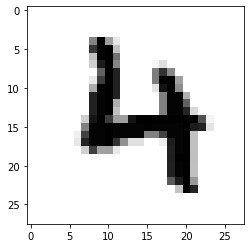

In [ ]:
some_digits = X[37000]
some_digits_image = some_digits.reshape(28,28)
plt.imshow(some_digits_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("on")
plt.show()

In [ ]:
y[37000]

'4'

**Splitting training dn testing data sets**

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffling training datasets to guarantee that all cross validation folds will be similar 

In [ ]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

lets train a binary classification model. here we are creating creating a data sets that has only number 5 so that the binary classifier will only classify the data as 5 or not 5

In [ ]:
y_train_7 = (y_train == '9') # True for all 5s, False for all other digits.
y_test_7 = (y_test == '9')

we will train Stochastic Gradient Descent(SGD) classifier as it is very efficient with large data sets

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_cls = SGDClassifier()
sgd_cls.fit(X_train,y_train_7)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
print(sgd_cls.predict([X_train[2]]))
y_train[2]

[False]


'6'

A good way to evaluate a model is cross validation. we can implement cross-validation using below code

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_7):
  clone_clf = clone(sgd_cls)
  X_train_folds = X_train[train_index]
  X_test_folds = X_train[test_index]
  y_train_folds = (y_train_7[train_index])
  y_test_folds = (y_train_7[test_index])

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.93165
0.9503
0.8638


lets use cross_val_score() function from sklearn to  check our score

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_cls,X_train,y_train_7,cv=3,scoring="accuracy")

array([0.93165, 0.94365, 0.95055])

This is good news as our accuracy is over 94%. Wait!!!
that's not it. let us consider there are 10% of number 5 images in that data set andif our model predicts not 5 all  the time it ends up with 90% accuracy.
So, this is the reason why accuracy is not a good measure for classifiers
there for we use confusion matrix to evaluate a classifier. we can use cross_val_predict() function

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_cls,X_train,y_train_7,cv=3)

we can use confusion_matrix() function from sklearn.metrics to calculate confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7,y_train_pred)

array([[52512,  1539],
       [ 1696,  4253]])

confusion matrix gives information about true positives, true negatives, false positives and false negatives.
We can further calculate precision and recall for the classifier using preision_score and recall_score from sklearn.metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("precision of SGD classifier: ",precision_score(y_train_7,y_train_pred))
print("Recall of SGD classifier: ", recall_score(y_train_7,y_train_pred))

precision of SGD classifier:  0.7342886740331491
Recall of SGD classifier:  0.7149100689191461


we can further combine precision and recall into a single metrics called F1 score. this is a harmonic mean of precision and recall. This will give high weights for low values which means F1 score will be high if and only if both precision and recall scores are high.
we can use f1_score() function from sklearn.metrics

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_train_7,y_train_pred))

0.7244698066604207


SGD works with decision boundary, we can get scores for each instance instead of predicted classes. so that we can later change the decision boundary and increase precision or recall for our classifier. but  there is a trade off between precision and recall. if recall increases precision decreases and vice versa. we can get scores for each instance by using cross_val_predict() function with method="decision_function" attribute

In [ ]:
y_scores = cross_val_predict(sgd_cls,X_train,y_train_7,method="decision_function")

with these y_scores we can calculate precision and recalls for all possible decision boundaries using precision_recall_curve() function

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recall, thresholds = precision_recall_curve(y_train_7,y_scores)

Using matplotlib we can plot precision and recall graphs for all decision boundaries

In [ ]:
def precision_recall_vs_thresholds(precisions, recall, thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Prcision")
  plt.plot(thresholds,recall[:-1],"g-",label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.title('Precision-Recall tradoff')
  plt.ylim([0,1])

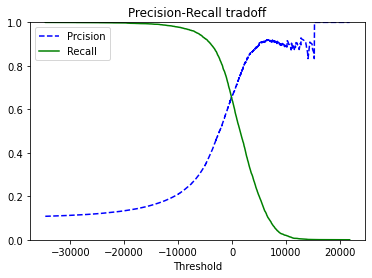

In [ ]:
precision_recall_vs_thresholds(precisions, recall, thresholds)
plt.show()

In [ ]:
def precision_vs_recall(precisions, recall):
  plt.plot( recall[:-1],precisions[:-1],'b-')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Precision vs Recall')
  plt.show()

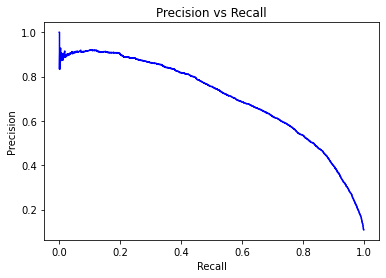

In [ ]:
precision_vs_recall(precisions, recall)

lets select a threshold such that our precision becomes 905. for that check precision-recall vs threshold map and selct threshold where precision is 90%. that is around 10000. use below code to set threshold for 10000

In [ ]:
y_train_pred_90 = (y_scores>10000)
print(precision_score(y_train_7,y_train_pred_90))
print("Recall when precison is above 90% :", recall_score(y_train_7,y_train_pred_90))

0.8897058823529411
Recall when precison is above 90% : 0.020339552866027902


ROC curve: 
          Receiver operating characteristic(ROC) is used to plot recall vs 1-true negative rate. True negative (false positive rate) is also called as specificity. so, we can say that roc curve is senstivity vs  specificity. we can use roc_curve() function from sklearn.metrics

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_7,y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

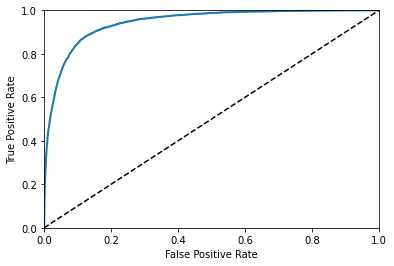

In [ ]:
plot_roc_curve(fpr, tpr  )

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_7,y_scores))

0.943829719302321


### Multi Class Classification
In this we can use binary classifier for multi class clasification
Here we use two methods one vs all & one vs one
Sklearn by default uses one vs all for all binary classifiers except for svm classifiers

In [ ]:
sgd_cls.fit(X_train,y_train)
sgd_cls.predict([some_digits])

array(['4'], dtype='<U1')

Whena classifier is train it will store the list of target classes in classes_ array.

In [ ]:
some_digits_score= sgd_cls.decision_function([some_digits])
sgd_cls.classes_[np.argmax(some_digits_score)]

'4'

Training a randomforest classifier is also easy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Here sklearn did not force to run OvsALL or OvsO because Randomforest classifier is capable of classifying instances into multiple classes

In [ ]:
print(forest_clf.predict([some_digits]))
forest_clf.predict_proba([some_digits])

['4']


array([[0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  ]])

Cross validation for OvsO or OvsALL classifiers
we can do that by using cross_val_score
we got scores over 86 in 3 folds which is not bad as if we use random classifier we would get 10% accuracy.

In [ ]:
cross_val_score(sgd_cls,X_train,y_train,cv=3,scoring='accuracy')

array([0.87095, 0.86725, 0.88745])

the score can be improved by scaling the input. With the help of StandardScalar from sklearn.preprocessing we can scale our input data

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train__scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_cls,X_train__scaled,y_train,cv=3,scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89275, 0.90505, 0.90125])

In [ ]:
y_train_pred = cross_val_predict(sgd_cls,X_train__scaled,y_train,cv=3)
conf_mtx = confusion_matrix(y_train,y_train_pred)
conf_mtx

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5597,    0,   16,    5,    9,   44,   34,    6,  211,    1],
       [   1, 6415,   46,   23,    5,   41,    4,    8,  188,   11],
       [  26,   28, 5261,   89,   74,   26,   62,   40,  345,    7],
       [  25,   18,  122, 5250,    0,  206,   24,   41,  376,   69],
       [  11,   18,   38,   12, 5256,   11,   35,   21,  294,  146],
       [  29,   19,   32,  148,   59, 4480,   70,   17,  506,   61],
       [  28,   18,   51,    1,   42,   87, 5549,    6,  136,    0],
       [  17,   12,   54,   24,   53,   12,    6, 5699,  172,  216],
       [  18,   65,   42,   96,    3,  114,   31,    8, 5431,   43],
       [  24,   22,   30,   61,  126,   37,    1,  170,  325, 5153]])